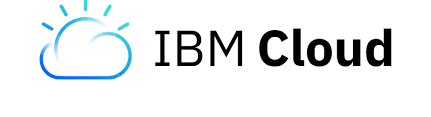

## CASE STUDY - Deploying a recommender

For this lab we will be using the MovieLens data :

* [MovieLens Downloads](https://grouplens.org/datasets/movielens/latest/)

download either **ml-latest-small.zip** or **ml-latest.zip** from this link and add the unziped folder to the data folder of the lab directory. We recommend you to use the small version if you are not working with a Spark cluster or a High memory machine.

The two important pages for documentation are below.

* [Spark MLlib collaborative filtering docs](https://spark.apache.org/docs/latest/ml-collaborative-filtering.html) 
* [Spark ALS docs](https://spark.apache.org/docs/latest/api/python/pyspark.mllib.html#pyspark.mllib.recommendation.ALS)


In [1]:
import os
import shutil
import pandas as pd
import numpy as np
import pyspark as ps
from pyspark.ml import Pipeline
from pyspark.sql import Row
from pyspark.sql.types import DoubleType

DATA_DIR = os.path.join("..", "data")
SAVE_DIR = os.path.join("..", "saved-recommender")

if os.path.isdir(SAVE_DIR):
    shutil.rmtree(SAVE_DIR)

In [2]:
## ensure the spark context is available
spark = (ps.sql.SparkSession.builder
        .appName("sandbox")
        .getOrCreate()
        )

sc = spark.sparkContext
print(spark.version) 

3.5.0


### Ensure the data are downloaded, unziped and placed in the data folder of this lab.

The data can be downloaded <a href="https://grouplens.org/datasets/movielens/">here</a>. We recommend you to download the small version: <b>ml-latest-small.zip</b>

In [10]:
ratings_file = os.path.join("work", "ratings.csv")


In [11]:
ratings_file = os.path.join("/home/jovyan/work", "ratings.csv")


In [24]:
df = spark.read.format("csv").options(header="true", inferSchema="true").load(ratings_file)
df = df.withColumnRenamed("movieID", "movie_id")
df = df.withColumnRenamed("userID", "user_id")
df.show(n=4)


+-------+--------+------+---------+
|user_id|movie_id|rating|timestamp|
+-------+--------+------+---------+
|      1|       1|   4.0|964982703|
|      1|       3|   4.0|964981247|
|      1|       6|   4.0|964982224|
|      1|      47|   5.0|964983815|
+-------+--------+------+---------+
only showing top 4 rows



In [26]:
# Define the correct path to the ratings data file
ratings_file = os.path.join("/home/jovyan/work", "ratings.csv")  # Absolute path inside Docker container

# Load the ratings data as a PySpark DataFrame
df = spark.read.format("csv").options(header="true", inferSchema="true").load(ratings_file)

# Renaming the 'movieID' and 'userID' columns for consistency
df = df.withColumnRenamed("movieID", "movie_id")
df = df.withColumnRenamed("userID", "user_id")

# Show the first 4 rows of the DataFrame
df.show(n=4)


+-------+--------+------+---------+
|user_id|movie_id|rating|timestamp|
+-------+--------+------+---------+
|      1|       1|   4.0|964982703|
|      1|       3|   4.0|964981247|
|      1|       6|   4.0|964982224|
|      1|      47|   5.0|964983815|
+-------+--------+------+---------+
only showing top 4 rows



In [27]:
# Define the correct path to the movies data file
movies_file = os.path.join("/home/jovyan/work", "movies.csv")  # Absolute path inside Docker container

# Load the movies data as a PySpark DataFrame
movies_df = spark.read.format("csv").options(header="true", inferSchema="true").load(movies_file)

# Renaming the 'movieID' column to 'movie_id' for consistency
movies_df = movies_df.withColumnRenamed("movieID", "movie_id")

# Show the first 4 rows of the DataFrame
movies_df.show(n=4)


+--------+--------------------+--------------------+
|movie_id|               title|              genres|
+--------+--------------------+--------------------+
|       1|    Toy Story (1995)|Adventure|Animati...|
|       2|      Jumanji (1995)|Adventure|Childre...|
|       3|Grumpier Old Men ...|      Comedy|Romance|
|       4|Waiting to Exhale...|Comedy|Drama|Romance|
+--------+--------------------+--------------------+
only showing top 4 rows



## QUESTION 1

Explore the movie lens data a little and summarize it.

In [36]:
# Show the summary statistics for the ratings data
ratings_df.describe().show()

# Count the number of unique users and movies
unique_users = ratings_df.select("user_id").distinct().count()
unique_movies = ratings_df.select("movie_id").distinct().count()

# Count movies with rating > 2, > 3, and > 4
movies_rating_gt_2 = ratings_df.filter(ratings_df.rating > 2).select("movie_id").distinct().count()
movies_rating_gt_3 = ratings_df.filter(ratings_df.rating > 3).select("movie_id").distinct().count()
movies_rating_gt_4 = ratings_df.filter(ratings_df.rating > 4).select("movie_id").distinct().count()

# Display the results
print(f"Unique users: {unique_users}")
print(f"Unique movies: {unique_movies}")
print(f"Movies with Rating > 2: {movies_rating_gt_2}")
print(f"Movies with Rating > 3: {movies_rating_gt_3}")
print(f"Movies with Rating > 4: {movies_rating_gt_4}")


+-------+------------------+----------------+------------------+--------------------+
|summary|           user_id|        movie_id|            rating|           timestamp|
+-------+------------------+----------------+------------------+--------------------+
|  count|            100836|          100836|            100836|              100836|
|   mean|326.12756356856676|19435.2957177992| 3.501556983616962|1.2059460873684695E9|
| stddev| 182.6184914635004|35530.9871987003|1.0425292390606342|2.1626103599513078E8|
|    min|                 1|               1|               0.5|           828124615|
|    max|               610|          193609|               5.0|          1537799250|
+-------+------------------+----------------+------------------+--------------------+

Unique users: 610
Unique movies: 9724
Movies with Rating > 2: 8852
Movies with Rating > 3: 7363
Movies with Rating > 4: 4056


## QUESTION 2

Find the ten most popular movies. 


1. Create 2 pyspark dataframes one with the count of each film in df and one with the average rating of each movie in df.
2. Join these two dataframes in a third dataframe. Then, filter this dataframe to select only the movies that have been seen more than 100 times.
3. Use the movies_df dataframe to add the names of each movies on the dataframe created in 2. Then, order the dataframe by descending average rating.



In [37]:
# 1_ Count the number of ratings for each movie
movie_counts = ratings_df.groupBy("movie_id").count()

# Calculate the average rating for each movie
top_rated = ratings_df.groupBy("movie_id").avg("rating")

# 2_ Join the two DataFrames (movie_counts and top_rated)
top_movies = movie_counts.join(top_rated, on="movie_id", how="inner")

# 3_ Filter out movies that have been rated fewer than 100 times
top_movies = top_movies.filter(top_movies["count"] > 100)

# Join with the movies DataFrame to get movie names and genres
top_movies = top_movies.join(movies_df, on="movie_id", how="inner")

# 4_ Order the movies by descending average rating
top_movies = top_movies.orderBy(top_movies["avg(rating)"], ascending=False)

# Select the relevant columns (movie_id, avg(rating), count, title, genres)
top_movies = top_movies.select("movie_id", "avg(rating)", "count", "title", "genres")

# Show the top 10 most popular movies
top_movies.show(10)


+--------+-----------------+-----+--------------------+--------------------+
|movie_id|      avg(rating)|count|               title|              genres|
+--------+-----------------+-----+--------------------+--------------------+
|     318|4.429022082018927|  317|Shawshank Redempt...|         Crime|Drama|
|     858|        4.2890625|  192|Godfather, The (1...|         Crime|Drama|
|    2959|4.272935779816514|  218|   Fight Club (1999)|Action|Crime|Dram...|
|    1221| 4.25968992248062|  129|Godfather: Part I...|         Crime|Drama|
|   48516|4.252336448598131|  107|Departed, The (2006)|Crime|Drama|Thriller|
|    1213|             4.25|  126|   Goodfellas (1990)|         Crime|Drama|
|   58559|4.238255033557047|  149|Dark Knight, The ...|Action|Crime|Dram...|
|      50|4.237745098039215|  204|Usual Suspects, T...|Crime|Mystery|Thr...|
|    1197|4.232394366197183|  142|Princess Bride, T...|Action|Adventure|...|
|     260|4.231075697211155|  251|Star Wars: Episod...|Action|Adventure|...|

## QUESTION 3

We will now fit a ALS model, this is matrix factorization model used for rating recommendation. See the [Spark ALS docs](https://spark.apache.org/docs/latest/api/python/pyspark.mllib.html#pyspark.mllib.recommendation.ALS)
for example usage. 

First we split the data

In [38]:
(training, test) = df.randomSplit([0.8, 0.2])

Create a function called **train_model()** that takes two inputs :

1. ``reg_param`` : the regularization parameter of the factorization model
2. ``implicit_prefs`` : a boolean variable that indicate whereas the model should used explicit or implicit ratings.
    
The function train an ALS model on the training set then predict the test set and evaluate this prediction.
The output of the function should be the RMSE of the fitted model on the test set./

In [39]:
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS
import numpy as np

def train_model(reg_param, implicit_prefs=False):
    """
    Train and evaluate an ALS model
    Inputs:
        reg_param (float): The regularization parameter of the ALS model.
        implicit_prefs (bool): A flag indicating whether the model should use implicit ratings.
        
    Outputs:
        RMSE (float): The Root Mean Squared Error (RMSE) of the fitted model on the test set.
    """
    # Initialize the ALS model
    als = ALS(userCol="user_id", itemCol="movie_id", ratingCol="rating", 
              regParam=reg_param, implicitPrefs=implicit_prefs, coldStartStrategy="drop")
    
    # Fit the model on the training data
    model = als.fit(training)
    
    # Make predictions on the test data
    predictions = model.transform(test)
    
    # Initialize the evaluator to calculate RMSE
    evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating", predictionCol="prediction")
    
    # Evaluate the RMSE of the model on the test set
    rmse = evaluator.evaluate(predictions)
    
    # Print the result
    print(f"regParam={reg_param}, RMSE={np.round(rmse, 2)}")

    return rmse


Calling the function created above for several ``reg_param`` values find the best regularization parameter.

In [40]:
for reg_param in [0.01, 0.05, 0.1, 0.15, 0.25]:
    train_model(reg_param)

regParam=0.01, RMSE=1.12
regParam=0.05, RMSE=0.94
regParam=0.1, RMSE=0.88
regParam=0.15, RMSE=0.87
regParam=0.25, RMSE=0.9


## QUESTION 4

With your best regParam try using the `implicitPrefs` flag.

>Note that the results here make sense because the data are `explicit` ratings

In [41]:
# Assuming the best regularization parameter from Question 3 is 0.05 (replace with the best one you got)
best_reg_param = 0.05  # Replace with your best reg_param value

# Train and evaluate the ALS model with implicitPrefs set to True
print(f"Training with reg_param={best_reg_param} and implicitPrefs=True")
train_model(best_reg_param, implicit_prefs=True)


Training with reg_param=0.05 and implicitPrefs=True
regParam=0.05, RMSE=3.23


3.2255577890312352

## QUESTION 5

Retrain the model with your best ``reg_param`` and ``implicit_prefs`` on the entire dataset and save the trained model in the SAVE_DIR directory.

In [43]:
# Assuming the best regularization parameter from Question 3 is 0.05 (replace with the best one you got)
best_reg_param = 0.05  # Replace with the best reg_param obtained earlier

# Re-train the model using the entire dataset
print("...training")
als = ALS(userCol="user_id", itemCol="movie_id", ratingCol="rating", 
          regParam=best_reg_param, implicitPrefs=True, coldStartStrategy="drop")
model = als.fit(ratings_df)  # Use the entire ratings data (ratings_df)

# Save the trained ALS model in the SAVE_DIR
print("...saving ALS model")
model.save(SAVE_DIR)  # Saving the model to the specified directory

print("done.")


...training
...saving ALS model
done.


## QUESTION 6

We now want to use ``spark-submit`` to load the model and demonstrate that you can load the model and interface with it.

Following the best practices we created a python script (``recommender-submit.py``) in the **scripts** folder that loads the model, creates some hand crafted data points and query the model. We recommend you to go over this script and make sure you understand it before running it through this notebook.

In [52]:
!python recommender-submit.py


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/02/15 08:04:08 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/02/15 08:04:09 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
best rated [(260,), (2628,), (1196,), (122886,), (187595,), (179819,), (1210,)]
25/02/15 08:04:20 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.VectorBLAS
closest_users                                                                   
 [(596,), (561,), (599,), (380,), (292,), (21,), (586,), (534,), (18,), (305,), (483,), (68,), (573,), (448,), (328,), (352,), (414,), (63,), (514,), (160,), (288,), (91,), (249,), (603,), (62,), (555,), (19,), (220,), (590,), (57,), (45,), (313,), (217,), (330,), (425,), (135,), (202,), (332,), (239,), (520,), (580,), (570,), (489,), (434,), (452,), (182

In [53]:
!spark-submit recommender-submit.py


25/02/15 08:06:00 INFO SparkContext: Running Spark version 3.5.0
25/02/15 08:06:00 INFO SparkContext: OS info Linux, 5.15.167.4-microsoft-standard-WSL2, amd64
25/02/15 08:06:00 INFO SparkContext: Java version 17.0.8.1
25/02/15 08:06:00 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/02/15 08:06:00 INFO ResourceUtils: ==============================================================
25/02/15 08:06:00 INFO ResourceUtils: No custom resources configured for spark.driver.
25/02/15 08:06:00 INFO ResourceUtils: ==============================================================
25/02/15 08:06:00 INFO SparkContext: Submitted application: recommend
25/02/15 08:06:00 INFO ResourceProfile: Default ResourceProfile created, executor resources: Map(cores -> name: cores, amount: 1, script: , vendor: , memory -> name: memory, amount: 1024, script: , vendor: , offHeap -> name: offHeap, amount: 0, script: , vendor: ), task resources